# 6 - Attention is All You Need

In this notebook we will be implementing a (slightly modified version) of the Transformer model from the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. All images in this notebook will be taken from the Transformer paper. For more information about the Transformer, [see](https://www.mihaileric.com/posts/transformers-attention-in-disguise/) [these](https://jalammar.github.io/illustrated-transformer/) [three](http://nlp.seas.harvard.edu/2018/04/03/attention.html) articles.

![](assets/transformer1.png)

The Transformer is a neural network architecture introduced in the paper "Attention Is All You Need" by Vaswani et al. in 2017. It is based solely on the self-attention mechanism, which allows it to process sequential data in parallel and efficiently model long-range dependencies. The Transformer has achieved state-of-the-art performance in several natural language processing tasks, including language modeling, machine translation, and text generation.

The Transformer consists of an encoder and a decoder, both composed of a stack of identical layers. Each layer has two sub-layers: a multi-head self-attention mechanism and a position-wise fully connected feed-forward network. Both sub-layers are followed by a residual connection and layer normalization.

The self-attention mechanism computes the representation of each input token based on its relationships with all the other tokens in the sequence. It applies three learned linear transformations to each token: a query, a key, and a value. These transformations project each token into three different spaces, which are used to calculate the attention scores between each pair of tokens. The attention scores are used to weight the values of each token, producing a weighted sum that represents the token's context within the sequence.

The multi-head attention mechanism improves the self-attention by using several parallel attention operations with different sets of learned query, key, and value transformations. This allows the model to capture multiple types of dependencies between different positions in the input sequence.

The position-wise feed-forward network applies a non-linear transformation to each token's representation independently. It helps the model to learn more complex relationships between the input tokens and their contexts.

The decoder uses a similar architecture as the encoder, with an additional multi-head attention sub-layer that attends over the encoder's output. The decoder also uses a masking mechanism to prevent it from attending to future tokens during training.

During training, the model is optimized to predict the next token in a sequence given the previous tokens, using a cross-entropy loss function. During inference, the model generates the output sequence autoregressively, by predicting one token at a time and feeding it back as input to predict the next token.


The differences between the implementation in this notebook and the paper are:
- we use a learned positional encoding instead of a static one
- we use the standard Adam optimizer with a static learning rate instead of one with warm-up and cool-down steps
- we do not use label smoothing

We make all of these changes as they closely follow BERT's set-up and the majority of Transformer variants use a similar set-up.

## Preparing the Data

As always, let's import all the required modules and set the random seeds for reproducability.

In [36]:
#Colab 사용을 위한 준비
#torchtext.legacy 사용을 위해 torchtext를 0.11.0으로 downgrade
# !pip install torchtext==0.11.0
#영어, 독일어 spacy 모델을 다운로드
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 7.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

반복 실행시 동일한 결과를 얻을 수 있도록 random seed를 지정

In [38]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

de_core_news_sm은 독일어 모델의 이름이며, en_core_web_sm은 영어 모델의 이름입니다. 이 모델들은 각각 독일어와 영어의 토큰화와 품사 태깅에 사용됨

In [39]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [40]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC field는 tokenize_de 함수를 사용하여 독일어 데이터를 토큰화하고, 문장의 시작과 끝을 나타내는 토큰으로 각각 <sos>와 <eos>를 사용하며, 대문자를 소문자로 바꾸는 옵션(lower=True)을 사용합니다. 마찬가지로, TRG field는 tokenize_en 함수를 사용하여 영어 데이터를 토큰화하고, <sos>와 <eos>를 사용하며, 대문자를 소문자로 바꾸는 옵션을 사용합니다.

batch_first=True는 모델이 데이터를 첫 번째 차원에 배치(batch)로 받는 것을 의미합니다. 즉, 모델이 입력으로 받는 데이터의 shape은 (batch_size, seq_len)이 됩니다.

In [41]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

Multi30k 클래스의 splits 메서드는 Multi30k 데이터셋을 학습, 검증, 테스트셋으로 분할하여 각각 train_data, valid_data, test_data 변수에 할당합니다. exts 인자는 사용할 언어를 지정하며, 이 경우 독일어(.de)와 영어(.en)를 사용합니다. fields 인자는 각 언어의 데이터를 처리하기 위해 앞서 정의한 SRC와 TRG 필드를 사용합니다.
BucketIterator를 사용하여 데이터를 미니배치로 분할하고, 각 미니배치의 크기를 최대한 동일하게 유지하면서 패딩을 추가합니다. 이를 통해 효율적인 모델 학습이 가능해집니다.

In [42]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

Field의 build_vocab 메서드는 데이터셋을 이용하여 vocabulary를 생성합니다. min_freq 인자는 말뭉치에서 최소한으로 출현한 빈도수를 지정합니다. min_freq 이상으로 출현한 단어들만 vocabulary에 추가됩니다. 이를 통해 vocabulary의 크기를 제한하고, 희귀한 단어를 제거할 수 있습니다. min_freq 미만으로 출현한 단어는 unk 토큰으로 대체됩니다.

SRC와 TRG field에서 각각 build_vocab 메서드를 호출하여 source vocabulary와 target vocabulary를 생성합니다. 이를 통해 각각의 unique token에 고유한 정수 인덱스가 매핑된 토큰의 집합인 vocabulary를 생성하고, 모델이 학습할 때 단어 대신 정수 인덱스가 사용되게 됩니다.

In [43]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

생성된 Vocabulary를 vocab.stoi로 확인할 수 있다.

In [44]:
print(len(SRC.vocab))
SRC.vocab.stoi

7853


defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7ff7fa55dd00>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             '.': 4,
             'ein': 5,
             'einem': 6,
             'in': 7,
             'eine': 8,
             ',': 9,
             'und': 10,
             'mit': 11,
             'auf': 12,
             'mann': 13,
             'einer': 14,
             'der': 15,
             'frau': 16,
             'die': 17,
             'zwei': 18,
             'einen': 19,
             'im': 20,
             'an': 21,
             'von': 22,
             'sich': 23,
             'dem': 24,
             'mädchen': 25,
             'junge': 26,
             'vor': 27,
             'zu': 28,
             'steht': 29,
             'männer': 30,
             'sitzt': 31,
             'hund': 32,
             'den': 33,
             'straße': 34,
             'während': 35,
  

In [45]:
print(len(TRG.vocab))
TRG.vocab.stoi

5893


defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7ff8296a80a0>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             'a': 4,
             '.': 5,
             'in': 6,
             'the': 7,
             'on': 8,
             'man': 9,
             'is': 10,
             'and': 11,
             'of': 12,
             'with': 13,
             'woman': 14,
             ',': 15,
             'two': 16,
             'are': 17,
             'to': 18,
             'people': 19,
             'at': 20,
             'an': 21,
             'wearing': 22,
             'shirt': 23,
             'young': 24,
             'white': 25,
             'black': 26,
             'his': 27,
             'while': 28,
             'blue': 29,
             'men': 30,
             'red': 31,
             'sitting': 32,
             'girl': 33,
             'boy': 34,
             'dog': 35,
             

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## 3. Model Architecture

모델 구조를 간단하게 설명하면, 인코더는 input sentence(논문에서는 input sequence of symbols라고 표현) $x_1,..., x_n$을 sequence of continuous representations인 $\bf{z}=(z_1,...,z_n)$으로 맵핑한다.<br>
디코더는 $\bf{z}$로부터 output sequence of symbols(출력 문장) $y_1,...,y_m$을 한 번에 한 element씩 생성한다. 각 스텝에서 디코더는 이전에 생성한 심볼(단어)들을 추가적인 입력으로 사용하여 다음 심볼을 생성한다.<br>
다른 모델들과 마찬가지로 토큰은 vocabulary의 정수 인덱스에서 벡터로 임베딩되어 모델에 주어진다. 다른 RNN 기반의 모델들과 다른 점은 논문이 제안하는 트랜스포머 구조는 RNN이 전혀 사용되지 않기 때문에, 입력되는 토큰들의 순서 정보를 positional encoding을 통해 추가해 주어야 한다는 것이다. 임베딩된 토큰 벡터에 positional encoding 벡터가 더해져 모델에 주어지게 된다.<br><br>


### 3.1 Encoder and Decoder Stacks
![](assets/transformer1.png)
인코더와 디코더는 각각 6개의 레이어로 구성되며, 레이어에는 multi-head self-attention 레이어와 position-wise fully connected feed-forward network가 포함됩니다. 각 서브레이어에는 residual connection과 normalization이 적용되며, 디코더의 multi-head self-attention은 masked multi-head self-attention으로 개조됩니다.

인코더와 디코더의 서브레이어인 position-wise feed-forward networks는 각각의 포지션에 대해 개별적으로 동일한 연산을 수행하며, 2개 층의 fully connected layer로 구성됩니다. 입력, 출력 토큰들은 임베딩 레이어를 통해 $d_{model}=512$차원의 벡터로 임베딩되고, 디코더 출력으로부터 다음 토큰의 확률을 계산하기 위해 fully connected layer와 소프트맥스 함수가 사용됩니다.

트랜스포머는 RNN이나 컨볼루션의 구조를 사용하지 않기 때문에, 시퀀스의 순서 정보를 포지션에 대한 정보를 positional encoding이라는 벡터로 더해줍니다. 이때 논문에서 제안한 static positional encoding 대신 learned positional encoding을 사용하는 경우 성능이 비슷하다고 언급되었습니다.

In [48]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        '''소스 문장이 토큰의 vocabulary에서의 정수 인덱스의 시퀀스 형태로 주어진다.
           주어진 토큰의 정수 인덱스는 self.tok_embedding 레이어에서 hid_dim 차원의 벡터로 임베딩된다.'''
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        '''논문에서는 정적인 상수 형태의 positional encoding을 사용하였으나 
           코드에서는 nn.Embedding 레이어를 사용해 학습되는 positional encoding을 사용하였다.'''
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        '''EncoderLayer를 n_layers만큼 사용하여 인코더를 구성한다.'''
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        '''dropout의 확률로 특정 노드의 값을 0으로 변경하는 레이어이다.'''
        self.dropout = nn.Dropout(dropout)
        '''tok_embedding 벡터와 pos_embedding 벡터를 더할 때의 가중치이다.'''
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        '''소스 문장의 토큰의 position을 나타내는 벡터 (0,1,...,src_len-1)를 torch.arange() 함수로 생성한다.
           batch_size만큼 생성한다.'''
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        '''pos의 크기, 값 확인
        print(pos.shape)
        print(pos)'''
        
        #pos = [batch size, src len]
        '''소스 시퀀스를 가공한다. self.tok_embedding()은 정수 시퀀스를 임베딩해 벡터 시퀀스를 만든다.
           벡터 시퀀스에 positional encoding(역시 벡터 시퀀스)을 self.pos_embedding으로 구해서 더한다.
           self.scale은 tok_embedding 벡터와 pos_embedding 벡터를 더할 때의 가중치에 해당한다.
           hid_dim이 증가해 모델 복잡도가 커질수록 tok_embedding 벡터에 더 높은 가중치를 둔다.(positional encoding의 정보량은 늘지 않기 때문에)
           positional encoding까지 마친 입력 시퀀스에 드롭아웃을 적용한다.'''
        '''src(임베딩 이전)의 크기, 값 확인
        print(src.shape)
        print(src)'''
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        '''src(임베딩 이후)의 크기, 값 확인
        print(src.shape)
        print(src)'''
        #src = [batch size, src len, hid dim]
        
        '''소스 시퀀스를 인코더 스택에 통과시킨다. 인코더 스택은 논문에서는 6개 층, 이 코드에서는 3개 층이다.
           src_mask는 논문에는 존재하지 않는데, 코드에서는 패딩 토큰을 마스킹하여 인코더의 어텐션이 패딩 토큰의
           정보를 학습하지 않게 하는 역할을 한다.'''
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

## 텐서 크기, 값 확인시 하이퍼파라미터
HID_DIM = 32<br>
ENC_LAYERS = 3<br>
DEC_LAYERS = 3<br>
ENC_HEADS = 4<br>
DEC_HEADS = 4<br>
ENC_PF_DIM = 64<br>
DEC_PF_DIM = 64<br>

### pos
크기 : (batch_size, src_len) <br>
torch.Size([128, 23]) <br>
tensor([[ 0,  1,  2,  ..., 20, 21, 22],<br>
        [ 0,  1,  2,  ..., 20, 21, 22],<br>
        [ 0,  1,  2,  ..., 20, 21, 22],<br>
        ...,<br>
        [ 0,  1,  2,  ..., 20, 21, 22],<br>
        [ 0,  1,  2,  ..., 20, 21, 22],<br>
        [ 0,  1,  2,  ..., 20, 21, 22]], device='cuda:0')<br>

### src (임베딩 이전)
크기 : (batch_size, src_len)
torch.Size([128, 23])<br>
tensor([[   2,    8,   16,  ...,    1,    1,    1],<br>
        [   2,   54, 1551,  ...,    1,    1,    1],<br>
        [   2,    5,  717,  ...,    1,    1,    1],<br>
        ...,<br>
        [   2,    8,   36,  ...,    1,    1,    1],<br>
        [   2,    5,   13,  ...,    1,    1,    1],<br>
        [   2,    5,   13,  ...,    1,    1,    1]], device='cuda:0')<br>

### src (임베딩 이후)
크기 : (batch_size, src_len, hid_dim)<br>
torch.Size([128, 25, 32]) <br>
tensor([[[ 0.0513,  0.0152,  0.0278,  ...,  0.2543,  0.0000, -0.2052],
         [-0.2462, -0.1523,  0.0130,  ...,  0.0828, -0.2669, -0.2605],
         [ 0.1117, -0.1667,  0.1654,  ...,  0.0000, -0.4095,  0.0165],
         ...,
         [ 0.2667, -0.2217,  0.2000,  ...,  0.0164,  0.3102,  0.0544],
         [ 0.0000, -0.0263,  0.0000,  ..., -0.3149,  0.0743,  0.1367],
         [ 0.0182,  0.1179,  0.2614,  ..., -0.3145,  0.0580,  0.0000]],

        ...,

        [[ 0.0513,  0.0152,  0.0278,  ...,  0.2543,  0.0993, -0.2052],
         [-0.0918, -0.1352,  0.0000,  ...,  0.3849, -0.1448, -0.4639],
         [ 0.0000, -0.4594, -0.1408,  ...,  0.2307, -0.2869,  0.2185],
         ...,
         [ 0.2667, -0.2217,  0.2000,  ...,  0.0164,  0.3102,  0.0544],
         [-0.1297, -0.0263,  0.0758,  ...,  0.0000,  0.0743,  0.1367],
         [ 0.0182,  0.0000,  0.2614,  ..., -0.3145,  0.0580, -0.0442]]],
       device='cuda:0', grad_fn=<FusedDropoutBackward0>)

### src mask
크기 : (batch_size, 1, 1, src_len) <br>
torch.Size([128, 1, 1, 33])<br>
tensor([[[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]],


        ...,


        [[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]]], device='cuda:0')

In [49]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        '''multi-head attention 레이어와 positionwise feed forward network에 적용되는 layer normalization 레이어이다.'''
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        '''Multi-head attention 레이어와 positionwise feed forward network이다.'''
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        '''Multi-head self attention을 수행한다. attention을 수행하는 대상은 이전 인코더 레이어에서 주어진 입력이다.
           Q, K, V가 모두 인코더의 이전 레이어에서 주어졌으므로 이 어텐션은 self attention이다.
           패딩 토큰에 대해서는 attention을 수행하지 않도록 패딩 토큰을 마스킹하는 src_mask를 같이 입력한다.'''
        '''print(src_mask.shape)
        print(src_mask)'''
        _src, _ = self.self_attention(src, src, src, src_mask)
        '''attention 레이어의 출력에 attention 레이어의 입력을 더해 residual connection을 구성하고 layer normalization을 수행한다.'''
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        '''위에서 계산한 결과를 position-wise FFN에 입력한다.
           똑같이 residual connection을 구성하고 layer normalization을 수행한다.'''
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

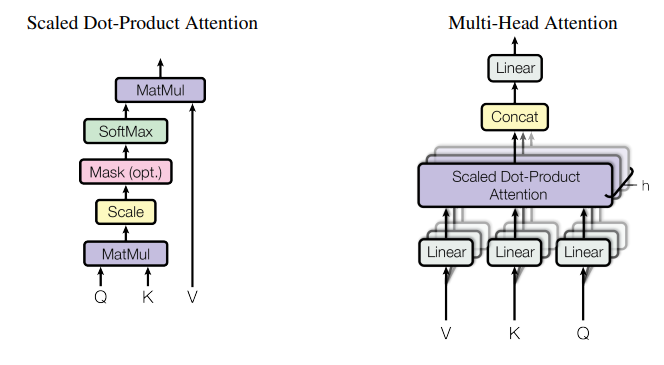

### 3.2 Attention
Attention is a function that maps query, key, and value vectors to an output. The output is a weighted sum of the value vectors, where the weights for each value are computed from the corresponding query and key vectors.
In the attention mechanism used in NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE, the output is denoted as $c_i$, the value vectors as $h_j$, the weights as $\alpha_{ij}$, and the query and key as $s_{i-1}$ and $h_j$, respectively.

#### 3.2.1 Scaled Dot-Product Attention
논문에서 사용된 어텐션은 내적(dot-product) 어텐션으로, 쿼리와 모든 키의 내적에 소프트맥스(softmax) 함수를 취해 가중치를 계산합니다. 하지만 내적값이 증가함에 따라 gradient가 작아지는 문제가 발생하므로, 내적 값을 $\sqrt{d_k}$로 나눠 스케일링하는 scaled dot-product attention을 사용합니다. 이 때, 쿼리, 키, 밸류는 모두 벡터이지만 모든 쿼리에 대해 한 번에 계산하기 위해 행렬 Q, K, V로 만들어 계산합니다.
$Attention(Q,K,V)=softmax(QK^T/\sqrt{d_k})V$ <br><br>

#### 3.2.2 Multi-Head Attention
저자는 $d_{model}$ 차원의 query, key, value를 $h$개의 $d_{k}, d_{v}$차원의 벡터로 linearly project하여 병렬적으로 attention을 적용하는 것이 이점이 있다고 했다. 이를 multi-head attention이라고 한다. <br>
Multi-head attention은 모델이 서로 다른 position에서 서로 다른 representation subspace의 정보를 사용할 수 있게 한다. (어텐션을 다양한 subspace에서 수행하여 모델이 여러 개의 어텐션을 학습할 수 있게 한다.)<br>
Multi-head attention을 수식으로 나타내면 아래와 같다.<br><br>
$MultiHead(Q,K,V)=Concat(head_{1},...,head_{h})W^{O}$<br>
where $head_{i}=Attention(QW_{i}^{Q},KW_{i}^{K},VW_{i}^{V})$<br><br>
논문에서는 $h=8$로 8개의 head를 사용하였고, 따라서 $d_{k}=d_{v}=d_{model}/h=64$이다.

#### 3.2.3 Applications of Attention in our Model
트랜스포머는 multi-head attention을 세 가지 방식으로 사용한다.
- 디코더의 두 번째(인코더의 출력과 연결된) multi-head attention<br>
이 경우 query는 이전 디코더 레이어에서, key와 value는 인코더의 출력에서 온다. Seq2Seq에 적용된 어텐션 메커니즘과 유사하며 디코더는 입력 시퀀스의 모든 포지션의 정보를 알 수 있다.<br><br>
- 인코더에 적용된 self-attention
인코더의 multi-head attention은 query, key, value가 모두 같은 곳(인코더의 이전 레이어)에서 온다. 이것을 self-attention이라고 한다. 인코더의 각 포지션은 인코더의 이전 레이어에서의 모든 포지션의 정보를 알 수 있다.<br><br>
- 디코더에 적용된 self-attention
인코더와 유사하게 디코더의 첫 번째 multi-head attention도 이전 디코더 레이어에서 query, key, value가 오는 self-attention이다. 이전 디코더 레이어에서 현재와 이전 포지션에 대한 정보를 알 수 있다. 현재와 이전 포지션 정보만 사용되는 이유는 미래 포지션들은 -inf로 마스킹 되어 있기 때문인데, 이렇게 마스킹하는 이유는 디코더가 현재 포지션의 출력을 생성할 때 다음 포지션의 출력을 고려하지 않게 하여 디코더의 auto-regressive한 특성을 유지하기 위해서이다.


## 4. Why Self-Attention


recurrent 또는 convolution layer같은 일반적으로 시퀀스를 같은 길이의 다른 시퀀스로 변환하는데 사용되는 layer 대신 Self-attention layer를 사용하는 이유는 아래와 같다.

- 레이어당 계산복잡도 (self-attention의 경우가 더 적음)
- 병렬화 가능한 연산의 양 (self-attention의 경우가 순차적인 연산을 덜 하고, 더 병렬적인 연산을 수행함. 즉, 속도가 빠름.)
- long-range dependency 사이의 path length가 짧음. (입력과 출력의 어떤 포지션이든 attention을 통해 조합이 가능하기 때문에, long-range dependency를 학습할 때도 짧은 path length를 가짐.)

부가적으로, self-attention이 더 interpretable한 모델을 생성한다는 장점도 있음. (모델의 attention distribution을 관찰할 수 있음)

In [50]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        '''Multi head attention을 적용할 때 head의 수에 해당한다.'''
        self.n_heads = n_heads
        '''hidden dimension을 head의 수로 나눈 차원으로 dot product attention을 수행한다.'''
        self.head_dim = hid_dim // n_heads
        
        '''multi-head attention layer에서 attention 이전에 q, k, v는 linear layer를 거치게 된다.
           attention 이전에 적용하는 linear layer에 해당한다.'''
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        '''attention 이후에 linear layer를 한 번 거치게 된다. attention 이후 linear layer에 해당한다.'''
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        '''multi head attention에서 softmax의 입력으로 사용되는 q와 k의 dot product를 스케일링하기 위한 값이다.'''
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        '''Q, K, V를 attention 이전에 각각 linear layer에 통과시킨다.'''        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
        '''linear layer를 통과한 Q, K, V에 multi-head attention을 적용하기 위해 텐서 형태를 아래와 같이 변경한다.'''
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        '''print(Q.shape, K.shape, V.shape)
        print('Q')
        print(Q)
        print('K')
        print(K)
        print('V')
        print(V)'''

        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
        '''Q와 K의 dot product를 계산하고 self.scale로 나눠준다.'''
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        '''인코더/디코더에서 주어진 마스크를 사용해 마스킹을 한다. 
           0으로 마스킹 된(가려진) 데이터의 energy는 -1e10으로 매우 작은 수로 변경되어 softmax를 거치면 0이 된다.'''
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        '''마스킹된 dot product에 softmax를 취한다.'''
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
        '''dot product attention으로 구한 가중치에 V를 곱한다.'''
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        '''attention을 적용하기 이전과 같은 차원으로 다시 차원을 변경한다.'''
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        '''attention 결과에 linear layer를 적용한다.'''
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Q, K, V 크기와 값
Q : torch.Size([128, 4, 25, 8]) <br>
K : torch.Size([128, 4, 25, 8]) <br>
V : torch.Size([128, 4, 25, 8])<br>
크기는 모두 같고 self-attention의 경우라도 값은 다르다. (fc_q/k/v 레이어를 통과하므로)<br>

Q <br>
tensor([[[[ 1.9152e+00,  1.9071e+00, -5.5274e-02,  ...,  1.6611e+00,
            1.0475e+00,  2.0021e+00],
          [ 2.3151e+00,  2.3640e+00,  2.9408e-01,  ...,  8.9106e-01,
            7.0929e-01,  1.4613e+00],
          [ 2.7746e+00,  2.2117e+00,  1.0765e-01,  ...,  1.4359e+00,
            9.3679e-01,  1.8722e+00],
        ...,

          [ 6.0945e-01,  8.8462e-01,  3.5919e-01,  ...,  2.4886e+00,
           -4.3781e-01,  9.0438e-01],
          [ 6.2848e-01,  1.1561e+00,  7.4230e-01,  ...,  2.2564e+00,
           -2.2896e-01,  6.0724e-01],
          [ 4.4555e-01,  1.2538e+00,  4.1791e-01,  ...,  2.4712e+00,
           -8.2704e-01, -4.7862e-02]]]], device='cuda:0',
       grad_fn=<PermuteBackward0>)
K<br>
tensor([[[[ 1.1512,  0.5304, -1.0808,  ..., -0.4342,  0.0207, -2.3666],
          [-0.9743,  0.7745,  0.9950,  ...,  0.9798,  0.3831, -0.6551],
          [ 0.3907, -0.3709, -0.1235,  ..., -0.1304,  1.1291, -0.6923],
        ...,

        [[[ 0.4394,  0.4389, -1.1297,  ..., -0.4129,  1.1842, -0.5171],
          [ 0.2317,  1.0126,  0.1946,  ..., -0.1930,  1.2992, -0.3748],
          [-1.1656, -0.3622,  0.9770,  ...,  0.6092,  0.2347,  0.0587],
          ...,
          [ 2.0912,  1.1560, -2.2640,  ..., -0.3742,  0.3477, -0.7300],
          [ 2.1262,  0.8503, -2.1531,  ..., -1.2906,  0.3677,  0.2180],
          [ 2.3698,  2.2134, -2.1801,  ..., -0.4639, -0.3328, -0.7250]]]],
       device='cuda:0', grad_fn=<PermuteBackward0>)
V<br>
tensor([[[[-6.0180e-01,  8.1828e-01, -3.2833e-02,  ...,  2.7038e+00,
            4.8775e-01, -3.1381e-01],
          [ 2.5379e+00, -4.7232e-01,  1.1093e+00,  ...,  9.8544e-01,
            1.8797e+00, -5.0071e-01],
          [ 3.4551e-01, -4.7018e-01,  8.8650e-01,  ...,  1.7246e+00,
           -1.0941e-01,  2.9779e-01],
        ...,

          [ 2.6860e-01, -5.6930e-01, -4.1412e-01,  ..., -2.0147e-01,
            7.3461e-01, -1.0395e+00],
          [ 9.6644e-02, -3.1975e-01,  2.6117e-01,  ...,  8.9116e-01,
            1.6241e+00, -9.1650e-01],
          [ 4.4789e-01, -9.3190e-01, -3.0298e-01,  ...,  4.9431e-01,
            9.3672e-01, -5.9890e-01]]]], device='cuda:0',
       grad_fn=<PermuteBackward0>)

In [51]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        '''positionwise feed forward layer는 2개의 linear layer로 구성된다.'''
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        '''2개의 linear layer에 x를 통과시킨다. 두 linear layer 사이의 활성화함수는 relu를 사용한다.'''
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [52]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        '''인코더와 거의 유사하다. 
           토큰은 vocabulary의 정수 인덱스로, 디코더에는 정수 시퀀스가 주어진다.
           정수 시퀀스를 임베딩 레이어를 사용해 벡터 시퀀스로 임베딩한다.'''
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        '''인코더와 마찬가지로 임베딩 레이어를 사용해 positional encoding을 수행한다.'''
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        '''n_layers 만큼의 decoder layer를 사용한다.'''
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        '''디코더의 출력은 확률분포로, target vocabulary의 토큰들이 해당 position의 토큰이 될 확률이 출력이다.
           확률분포를 출력하기 위해 hid_dim 차원의 벡터를 output_dim(target vocabulary의 토큰 수)로 변환하기 위해 사용되는 linear layer이다.'''
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        '''인코더와 마찬가지로 tok_embedding과 pos_embedding 벡터를 더할 때 사용되는 가중치이다.'''
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        '''trg_len 만큼의 position을 생성한다.'''
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
        '''토큰 임베딩 벡터와 포지셔널 인코딩 벡터의 weighted sum을 계산한다.'''
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        '''토큰 임베딩과 포지셔널 인코딩이 더해진 값을 디코더 레이어에 입력하여 trg, attention을 얻는다.'''
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        '''디코더 레이어에서 출력된 trg를 linear layer에 넣어 output(확률분포)를 얻는다.'''
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
        '''output과 attention을 리턴한다.'''
        return output, attention

## TRG
디코더에서 trg의 크기는 인코더의 src의 크기와 같다.

## TRG mask
tensor([[[[ True, False, False,  ..., False, False, False],<br>
          [ True,  True, False,  ..., False, False, False],<br>
          [ True,  True,  True,  ..., False, False, False],<br>
          ...,<br>
          [ True,  True,  True,  ..., False, False, False],<br>
          [ True,  True,  True,  ..., False, False, False],<br>
          [ True,  True,  True,  ..., False, False, False]]],<br><br>
True로 표시된 부분이 앞에서부터 하나씩 증가한다.

## Attention
torch.Size([128, 4, 40, 34]) <br>
tensor([[[[0.0465, 0.1171, 0.0504,  ..., 0.0000, 0.0000, 0.0000],<br>
          [0.0657, 0.0999, 0.0696,  ..., 0.0000, 0.0000, 0.0000],<br>
          [0.0578, 0.1107, 0.0697,  ..., 0.0000, 0.0000, 0.0000],<br>
          ...,
          [0.0689, 0.0968, 0.0577,  ..., 0.0000, 0.0000, 0.0000],<br>
          [0.0573, 0.0988, 0.0870,  ..., 0.0000, 0.0000, 0.0000],<br>
          [0.0679, 0.0955, 0.0698,  ..., 0.0000, 0.0000, 0.0000]],<br>
        ...,

        [[[0.0781, 0.0946, 0.0760,  ..., 0.0000, 0.0000, 0.0000],
          [0.0579, 0.0837, 0.0957,  ..., 0.0000, 0.0000, 0.0000],
          [0.0497, 0.0985, 0.0890,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1241, 0.0831, 0.0638,  ..., 0.0000, 0.0000, 0.0000],
          [0.1499, 0.0815, 0.0488,  ..., 0.0000, 0.0000, 0.0000],
          [0.1048, 0.1107, 0.0682,  ..., 0.0000, 0.0000, 0.0000]]]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [53]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        '''layer normalization을 위한 LayerNorm'''
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        '''이전 디코더 레이어에서 Q, K, V를 가져와 self-attention을 수행하는 multi head attention layer'''
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        '''이전 디코더 레이어에서 Q, 인코더에서 K, V를 가져와 attention을 수행하는 multi head attention layer'''
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        '''position wise feed forward network'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        '''이전 디코더 레이어의 출력 trg를 Q, K, V로 사용하여 self-attention을 수행한다.
           디코더가 이후 포지션의 토큰을 확인하지 못하도록 trg_mask를 사용하여 현재 포지션까지의 토큰들만 사용되도록 한다.
           self-attention 이후 residual connection을 형성하고 layernorm을 수행한다.'''
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        '''print(trg_mask)'''
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
        '''이전 디코더 레이어에의 출력을 Q, 인코더의 출력을 K, V로 사용하여 attention을 수행한다.
           여기서 사용되는 마스크는 인코더에 입력된 padding token을 마스킹하는 역할이다.
           attention 수행 후 residual connection을 형성하고 layernorm을 수행한다.'''
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        '''print(attention.shape)
        print(attention)'''
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        '''마지막으로 positionwise feedforward network를 사용한다.
           residual connection을 구성하고 layernorm을 수행한다.'''
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [54]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        '''소스 문장에서 패딩 토큰이 아닌 포지션은 1, 패딩 토큰의 포지션은 0이 되도록 마스킹한다.'''
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        '''타겟 문장에서 패딩 토큰이 아닌 포지션은 1, 패딩 토큰의 포지션은 0이 되도록 마스킹한다.'''
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        '''디코더에 주어지는 마스크는 디코더가 현재 포지션의 토큰까지만 확인하게 하는 역할을 하는데 그 역할을 하기 위해서 아래와 같은 마스크를 생성한다 (trg_len = 5인 경우).
            1  0  0  0  0
            1  1  0  0  0
            1  1  1  0  0
            1  1  1  1  0
            1  1  1  1  1
            '''
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
        '''두 마스크에서 모두 1인 부분만 1이 되도록 and 연산을 수행한다. (현재 또는 과거 포지션 중 패딩 토큰이 아닌 것들만 주어지도록)'''
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
        '''소스 마스크와 타겟 마스크를 생성한다.'''
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        '''소스 시퀀스를 인코더에 입력하여 enc_src를 얻는다.'''
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
        '''인코더의 출력과 타겟 문장을 입력하여(학습을 위한 입력, 실제 번역에서는 디코더가 출력한 단어가 입력되어야함) output을 계산한다.'''
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## 하이퍼파라미터 정의, 모델 학습

아래와 같이 하이퍼파라미터를 정의하고 모델을 학습시킨다.
인코더, 디코더 레이어 수는 논문에서는 6이었으나 코드에서는 3을 사용하였다.


In [55]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

패딩 토큰의 인덱스를 추출하고(패딩에 대해 로스 계산 안하기 위해서), 모델을 구성한다. 

In [56]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

파라미터의 수를 확인한다.

In [57]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


Xavier uniform이 가장 일반적인 가중치 초기화 방식이므로 이 방법으로 모델의 가중치를 초기화한다.

In [58]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [59]:
model.apply(initialize_weights);

논문에서는 Adam optimizer의 learning rate를 warm-up, cool-down period를 갖도록 설정했지만, 코드에서는 고정값을 사용한다.

In [60]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

패딩 토큰에 대해서는 로스가 계산되지 않도록 한다.

In [61]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [62]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        '''소스 문장과 타겟 문장을 모델에 입력하여 output을 얻는다.'''
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        '''모델 출력과 타겟을 사용하여 cross entropy loss를 계산한다.'''    
        loss = criterion(output, trg)
        '''loss 역전파를 실행한다.'''
        loss.backward()
        '''gradient clip을 수행(안정적인 학습을 위해)하고 파라미터를 업데이트한다.'''
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        '''평균 loss를 계산하고 반환한다.'''
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [63]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            '''train 함수에서 오차 역전파, 파라미터 업데이트가 제거된 코드이다.'''
            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

We then define a small function that we can use to tell us how long an epoch takes.

In [64]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [65]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
'''10 에포크만큼 학습시킨다.
   매 에포크마다 학습, 검증 loss와 perplexity를 출력한다.'''
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    '''현재 에포크의 검증 loss가 이전까지의 가장 작은 값보다 더 작으면 모델을 저장한다.
       (best model을 저장)'''
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 11s
	Train Loss: 4.226 | Train PPL:  68.450
	 Val. Loss: 3.025 |  Val. PPL:  20.594
Epoch: 02 | Time: 0m 11s
	Train Loss: 2.816 | Train PPL:  16.707
	 Val. Loss: 2.317 |  Val. PPL:  10.146
Epoch: 03 | Time: 0m 12s
	Train Loss: 2.241 | Train PPL:   9.406
	 Val. Loss: 1.980 |  Val. PPL:   7.241
Epoch: 04 | Time: 0m 12s
	Train Loss: 1.888 | Train PPL:   6.606
	 Val. Loss: 1.813 |  Val. PPL:   6.127
Epoch: 05 | Time: 0m 12s
	Train Loss: 1.643 | Train PPL:   5.168
	 Val. Loss: 1.706 |  Val. PPL:   5.505
Epoch: 06 | Time: 0m 16s
	Train Loss: 1.453 | Train PPL:   4.277
	 Val. Loss: 1.655 |  Val. PPL:   5.234
Epoch: 07 | Time: 0m 25s
	Train Loss: 1.301 | Train PPL:   3.674
	 Val. Loss: 1.634 |  Val. PPL:   5.123
Epoch: 08 | Time: 0m 55s
	Train Loss: 1.174 | Train PPL:   3.236
	 Val. Loss: 1.614 |  Val. PPL:   5.021
Epoch: 09 | Time: 0m 55s
	Train Loss: 1.064 | Train PPL:   2.898
	 Val. Loss: 1.627 |  Val. PPL:   5.087
Epoch: 10 | Time: 0m 54s
	Train Loss: 0.972 | Train PPL

Best model(검증 loss가 가장 작은 모델)을 불러온다.
불러온 모델을 test dataset으로 평가하여 test loss와 test perplexity를 계산한다.

In [66]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.662 | Test PPL:   5.268 |


## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [67]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
    '''소스 문장이 토큰화 되어있지 않으면(문자열이면) spacy 모델을 사용해 토큰화한다.'''    
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    #'''소스 문장이 토큰화 되어있으면 모두 소문자로 변경한다.'''
    else:
        tokens = [token.lower() for token in sentence]
    '''문장 시작에 sos, 문장 끝에 eos 토큰을 추가한다.'''
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    '''소스 문장을 토큰 인덱스(정수)의 시퀀스로 바꾼다.'''
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    '''패딩 토큰을 가리는 마스크를 만든다.'''
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        '''정수 시퀀스를 인코더에 넣어 context vector를 얻는다.'''
        enc_src = model.encoder(src_tensor, src_mask)
    
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        '''타겟 문장(정수 시퀀스)을 텐서로 변환'''
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        '''타겟 마스크를 생성한다. 디코더가 미래 포지션의 타겟 토큰을 알 수 없도록 한다.'''
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            '''타겟 문장, context vector, 타겟/소스 마스크를 입력해 output을 얻는다.'''
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        '''output은 확률분포의 시퀀스인데 argmax를 사용해 가장 높은 확률의 인덱스를 추출하여 예측한 문장(정수 시퀀스)을 얻는다.'''
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)
        '''디코더에서 eos 토큰이 출력되면 예측을 끝낸다.'''
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

## Attention 시각화

디코더의 인코더-디코더 어텐션을 시각화한다. 8개 head의 어텐션을 모두 시각화한다.

In [68]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Training 데이터셋의 예제

In [83]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', '.']
trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']


Our translation looks pretty good, although our model changes *is walking by* to *walks by*. The meaning is still the same.

In [70]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'by', 'a', 'gate', '.', '<eos>']


각 head의 attention을 볼 수 있다. 조금씩 다르지만 오른쪽 아래를 향하는 대각선의 형태이다.

/tmp/ipykernel_3975833/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_3975833/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


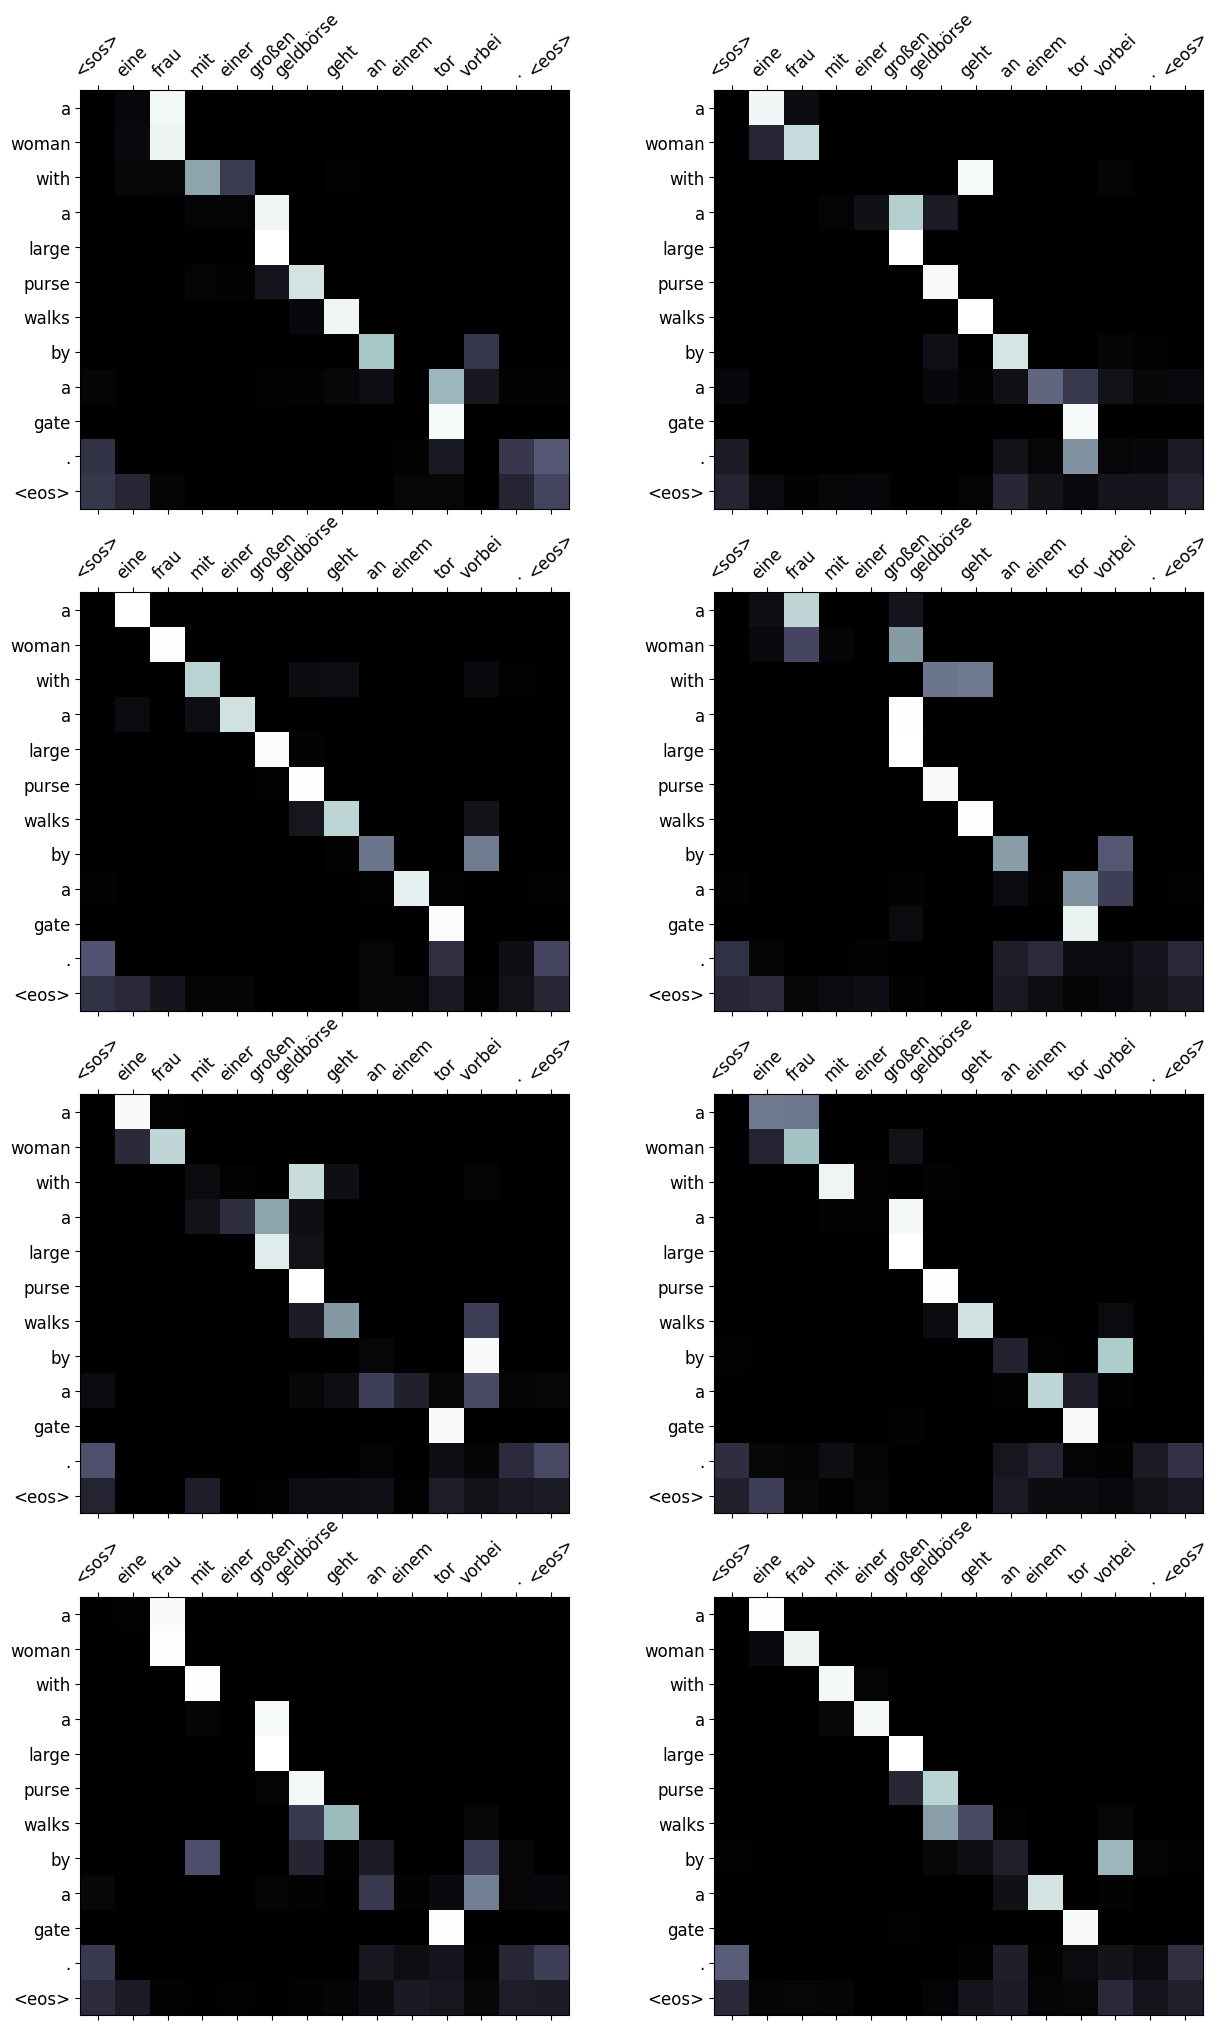

In [71]:
display_attention(src, translation, attention)

Validation set의 예제를 번역한다.

In [72]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


The model translates it by switching *is running* to just *runs*, but it is an acceptable swap.

In [73]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'running', 'after', 'a', 'black', 'dog', '.', '<eos>']


앞의 예제와 비슷하게 8개의 attention은 모두 다르지만 오른쪽 아래를 향하는 형태를 하고 있다.

/tmp/ipykernel_3975833/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_3975833/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


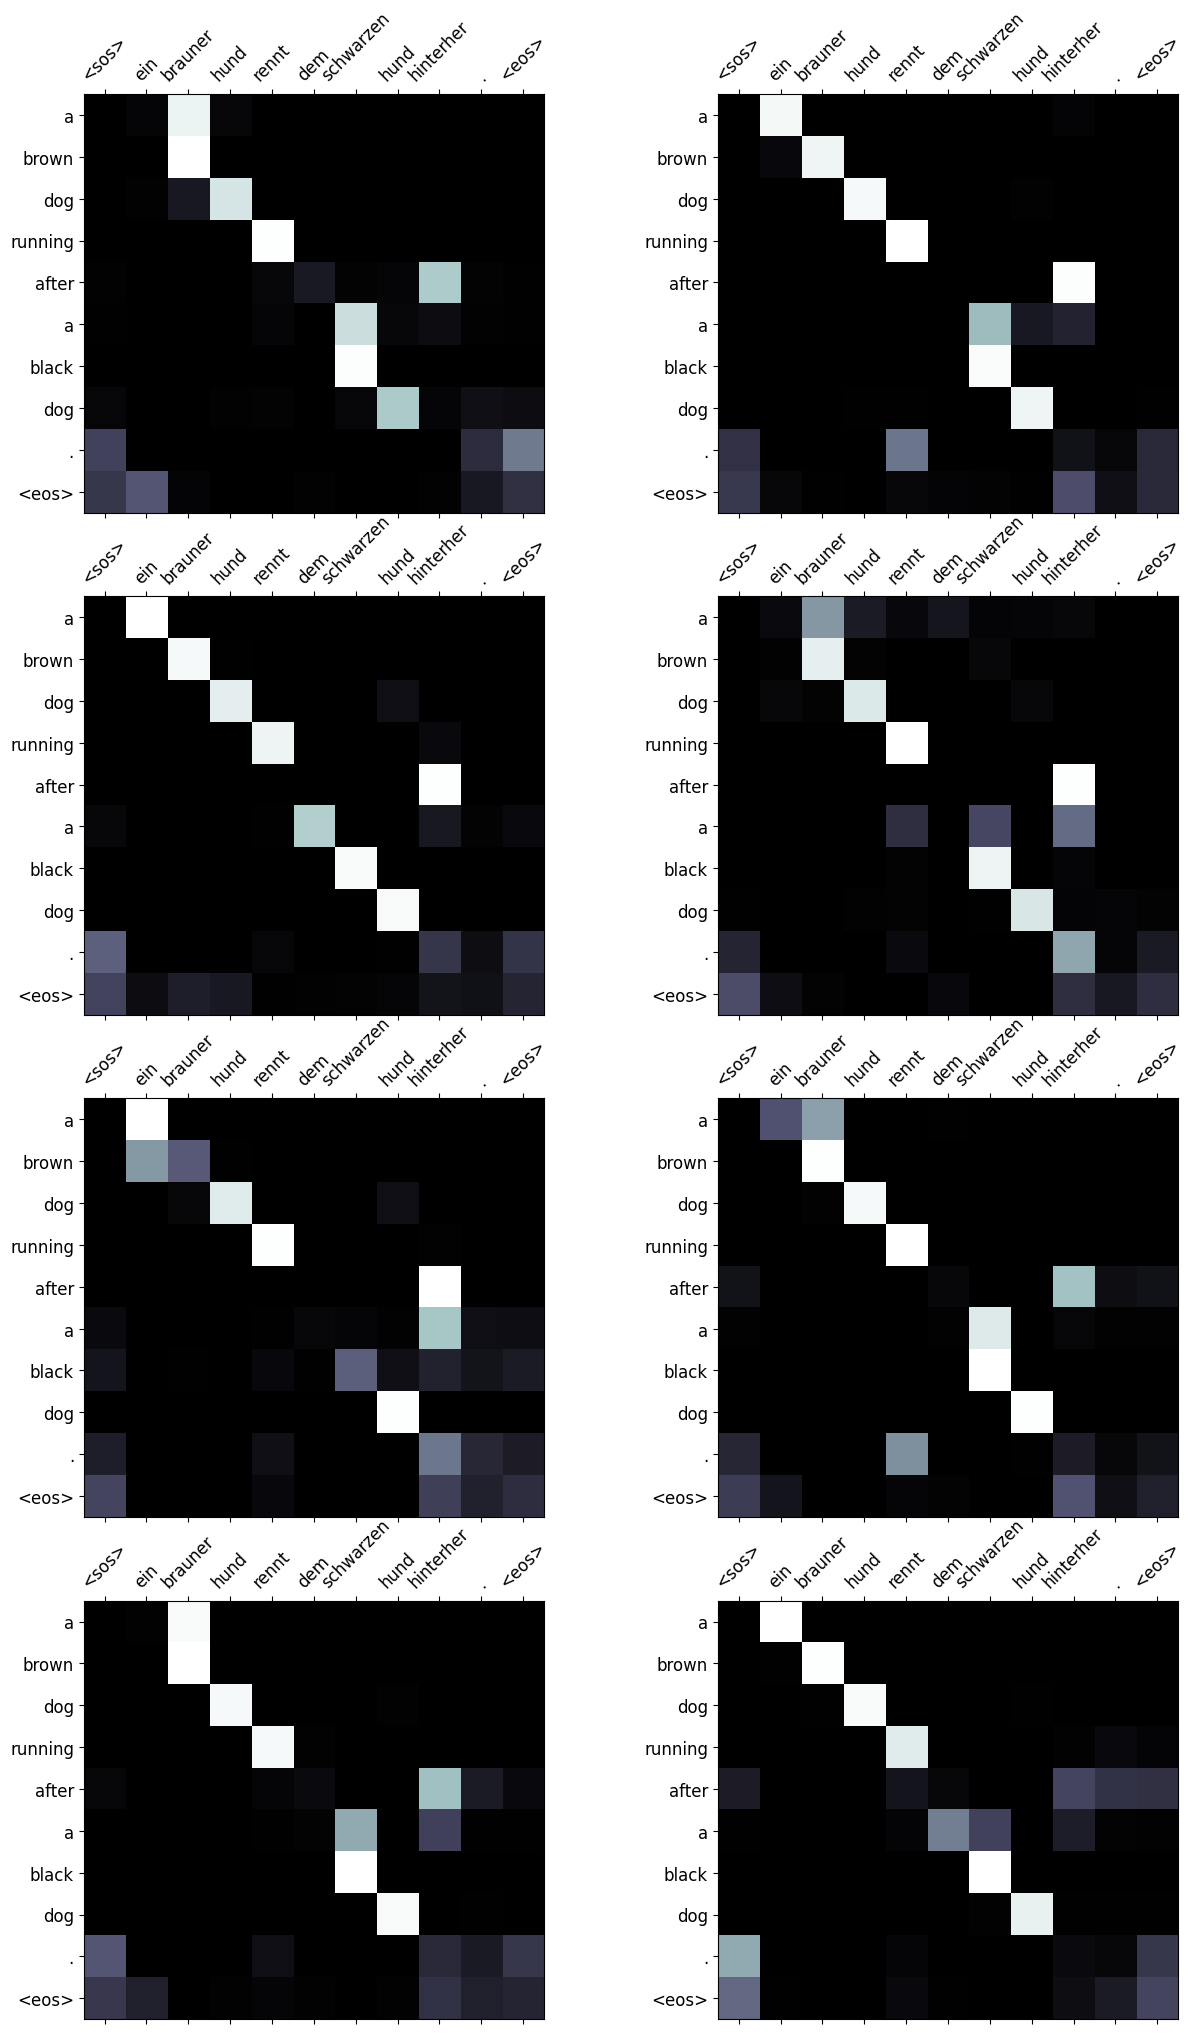

In [74]:
display_attention(src, translation, attention)

Test 데이터셋의 예제를 번역역

In [75]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


A perfect translation!

In [76]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']


/tmp/ipykernel_3975833/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_3975833/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


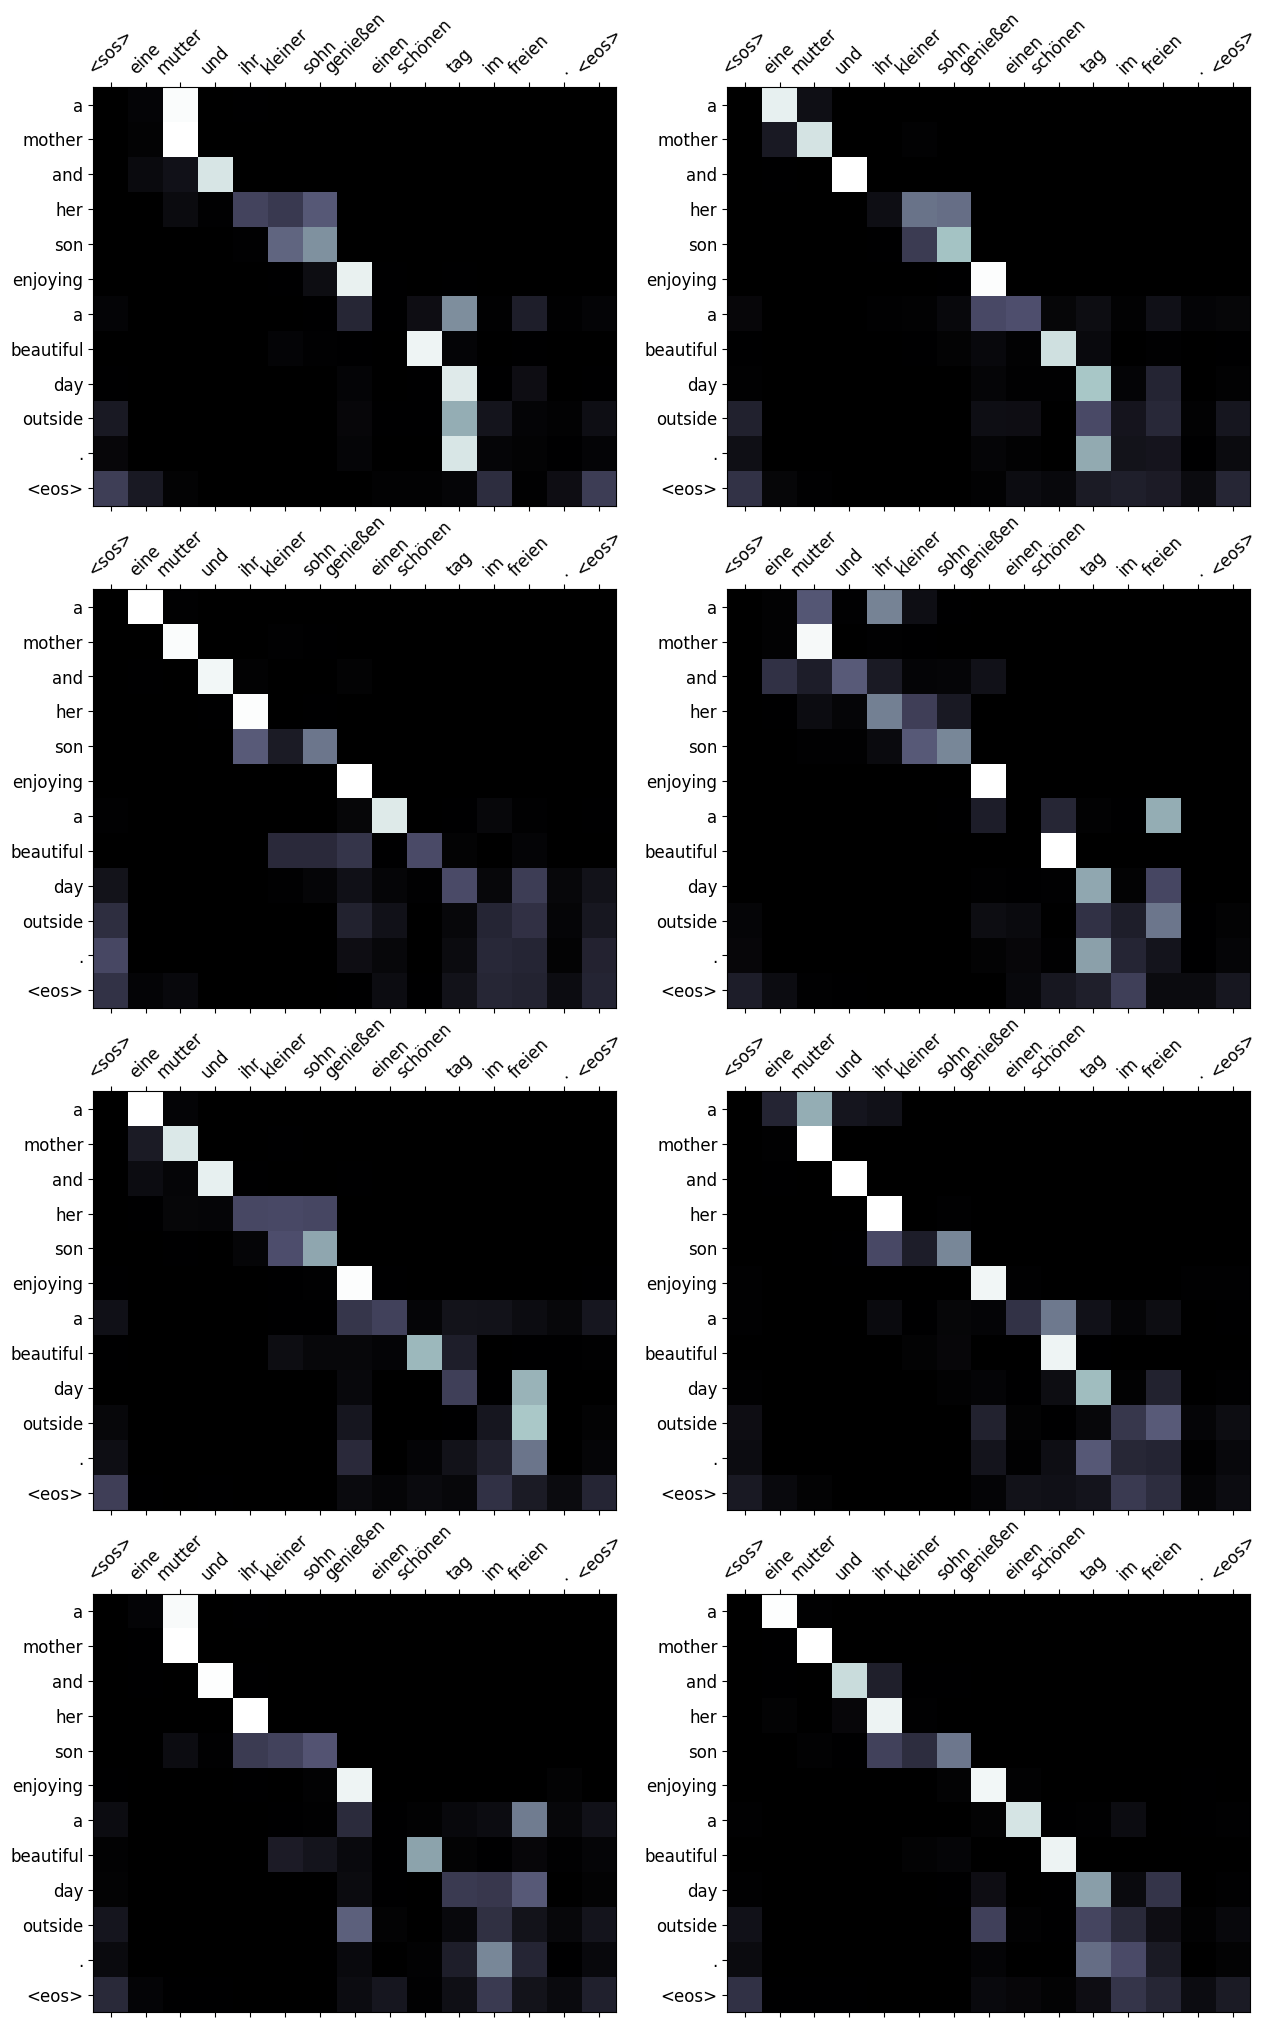

In [77]:
display_attention(src, translation, attention)

## BLEU

BLEU 점수를 계산한다. <br>
BLEU는 기계 번역 결과와 사람이 직접 번역한 결과가 얼마나 유사한지 비교하여 번역에 대한 성능을 측정하는 방법으로 n-gram 기반이다.<br>

In [78]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

트랜스포머 모델의 BLEU 점수는 35이다. <br>
RNN+어텐션 모델의 28점보다 높은 점수를 달성하면서도 병렬화가 잘 되어있어 학습 속도가 빠르다.

In [79]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 36.12


Congratulations for finishing these tutorials! I hope you've found them useful.

If you find any mistakes or want to ask any questions about any of the code or explanations used, feel free to submit a GitHub issue and I will try to correct it ASAP.

## Appendix

The `calculate_bleu` function above is unoptimized. Below is a significantly faster, vectorized version of it that should be used if needed. Credit for the implementation goes to [@azadyasar](https://github.com/azadyasar).

In [80]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [81]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)